In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
from desi_retriever.denali import get_specs
import matplotlib.cm as cm
import scipy.ndimage as sn

In [2]:
def print_simple_number(truth_table,object_type):
    total_N = len(truth_table)
    good_N = len(truth_table[truth_table['best_quality']>=2.5])
    very_good_N = len(truth_table[truth_table['best_quality']==4])
    tmp_table = truth_table.loc[truth_table['best_quality']>=2.5]
    number_of_consistent_z = len(tmp_table.loc[abs(tmp_table['best_z']-tmp_table['Redrock_z'])/(1+tmp_table['best_z'])<0.0033])
    
    print('Number of',object_type,':',total_N)
    print('Number of ',object_type,'with quality>=2.5:',good_N, ' | fration=',good_N*1.0/total_N)
    print('Number of ',object_type,'with quality==4:',very_good_N, ' | fration=',very_good_N*1.0/total_N)
    print('Number of ',object_type,'with consistent z (with quality>=2.5):',number_of_consistent_z, '| fraction=',number_of_consistent_z/total_N)
   
    number_star = len(tmp_table.loc[tmp_table['best_spectype']=='STAR'])
    number_galaxy = len(tmp_table.loc[tmp_table['best_spectype']=='GALAXY'])
    number_qso = len(tmp_table.loc[tmp_table['best_spectype']=='QSO'])
    print('---------')  
    print('Fraction of objects with quality>=2.5')
    print('Star:',number_star*1.0/good_N)
    print('Galaxy:',number_galaxy*1.0/good_N)    
    print('QSO:',number_qso*1.0/good_N)

    plt.hist(truth_table['best_quality'],bins=8,range=(0,4))
    plt.ylabel('Number')
    plt.xlabel('Quality')
    plt.yscale('log')
    plt.xlim(0,4)
  

In [3]:
def plot_redshift_distribution(truth_table,object_type):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    x_range = [0,max(truth_table.loc[truth_table['best_quality']>=2.5]['best_z'])]
    plt.hist(truth_table['best_z'],range=(x_range[0],x_range[1]),bins=20,color='b',label='All')
    plt.hist(truth_table.loc[truth_table['best_quality']>=2.5]['best_z'],range=(x_range[0],x_range[1]),bins=20,color='orange',label='quality>=2.5')
    plt.hist(truth_table.loc[truth_table['best_quality']==4]['best_z'],range=(x_range[0],x_range[1]),bins=20,color='g',label='quality=4')
    plt.yscale('log')
    plt.xlabel('Best z')
    plt.ylabel('Number')
    plt.legend()
    plt.title(object_type)
    
    plt.subplot(1,2,2)
    plt.scatter(truth_table.loc[truth_table['best_quality']>=2.5]['best_z'],truth_table.loc[truth_table['best_quality']>=2.5]['Redrock_z'],
                
                c=truth_table.loc[truth_table['best_quality']>=2.5]['best_quality'],cmap=cm.jet)
    plt.xlabel('Best z')
    plt.ylabel('Redrock z')
    plt.colorbar()

In [4]:
def plot_chi2_quality_distribution(truth_table):
    #plt.scatter(truth_table['best_quality'],truth_table['DELTACHI2'])
    #plt.ylim(1,100000)
    #plt.yscale('log')
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.hist(np.log10(truth_table['DELTACHI2']),label='All',bins=8,range=(0,5),color='b')
    plt.hist(np.log10(truth_table.loc[truth_table['best_quality']>=2.5]['DELTACHI2']),color='orange',label='flag>=2.5',bins=8,range=(0,5))
    plt.hist(np.log10(truth_table.loc[truth_table['best_quality']==4]['DELTACHI2']),color='g',label='flag=4',bins=8,range=(0,5),)
    plt.xlabel('$log_{10}$ delta chi$^{2}$')
    plt.ylabel('Number')
    plt.yscale('log')
    plt.legend()
    plt.subplot(1,2,2)
    
    plt.hist(np.log10(truth_table.loc[truth_table['best_quality']<2.5]['DELTACHI2']),color='grey',label='flag<2.5',bins=8,range=(0,5),histtype='step',lw=4)
    plt.hist(np.log10(truth_table.loc[truth_table['best_quality']>=2.5]['DELTACHI2']),color='orange',label='flag>=2.5',bins=8,range=(0,5),histtype='step',lw=4)
    #plt.hist(np.log10(truth_table.loc[truth_table['best_quality']==4]['DELTACHI2']),color='g',label='flag=4',bins=8,range=(0,5),histtype='step',lw=4)

    plt.xlabel('$log_{10}$ delta chi$^{2}$')
    plt.ylabel('Number')
    plt.yscale('log')
    plt.legend()    
    
    
    
    

In [5]:
def give_me_ra_dec_object_with_property_cut(truth_table, property_name, cut, if_print=True):
    tmp_table = truth_table.loc[(truth_table[property_name]>=cut[0]) & (truth_table[property_name]<cut[1])]
    if if_print==True:
        for i_object in range(0,len(tmp_table)):
            print(tmp_table['TARGET_RA'].values[i_object],tmp_table['TARGET_DEC'].values[i_object])
    
    return tmp_table

In [6]:
# The filenames are tentative. We will change the filenames.
on_nersc=False
if on_nersc==True:
    dir = '/global/cfs/cdirs/desi/sv/vi/TruthTables/Cascades/'
    BGS = pd.read_csv(dir+'BGS/'+'desi-vi_SV_cascades_combination_BGS_all_210521.csv')
    BGS['DELTACHI2']=BGS['Redrock_deltachi2']
    LRG = pd.read_csv(dir+'LRG/'+'desi-vi_SV_cascades_combination_LRG_all_210521.csv')
    LRG['DELTACHI2']=LRG['Redrock_deltachi2']
    ELG = pd.read_csv(dir+'ELG/'+'desi-vi_SV_cascades_combination_ELG_all_210521.csv')
    ELG['DELTACHI2']=ELG['Redrock_deltachi2']
    #ELG_80606 = pd.read_csv(dir+'ELG/'+'desi-vi_ELG_tile80606_nightdeep_merged_all_210218.csv')
else:
    #dir = '/Users/tlan/Dropbox/Astro_Research/Projects_plots_notes/2020_DESI_visual_inspect/SV1/Truth_tables/'
    LRG = pd.read_csv('/Users/blue/Dropbox/Astro_Research/Projects_plots_notes/2020_DESI_visual_inspect/SV_VI_cascades/Cascades/LRG/output/desi-vi_SV_cascades_combination_LRG_all_210521.csv')
    LRG['DELTACHI2']=LRG['Redrock_deltachi2']
    #LRG = pd.read_csv(dir+'desi-vi_LRG_tile80609_nightdeep_merged_all_210130.csv')
   

In [35]:
denali_all = Table.read('/Volumes/Elements/DESI/Denali/denali_alltiles_Allzinfo.fits')
denali_all = denali_all[denali_all['coadd_type']=='cumulative']
new_catalog_denali = denali_all['TARGETID','Z','subset','TILEID','DELTACHI2','TARGET_RA','TARGET_DEC','LAST_NIGHT',
                              'EFFTIME_BRIGHT','FIBERFLUX_R','FLUX_R','FIBERFLUX_Z','FLUX_W1','FLUX_G','FLUX_Z','EBV','ZWARN','FIBER'].to_pandas()

# LRG main z_deep<1.4 and non-repeatable redshifts

Number of LRG : 802
Number of  LRG with quality>=2.5: 754  | fration= 0.940149625935162
Number of  LRG with quality==4: 543  | fration= 0.6770573566084788
Number of  LRG with consistent z (with quality>=2.5): 638 | fraction= 0.7955112219451371
---------
Fraction of objects with quality>=2.5
Star: 0.09946949602122016
Galaxy: 0.8275862068965517
QSO: 0.07294429708222812


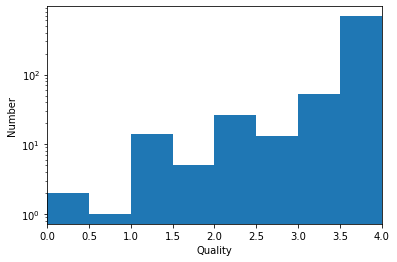

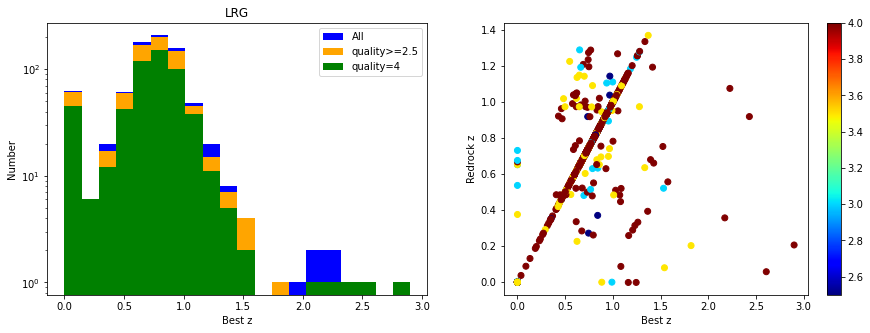

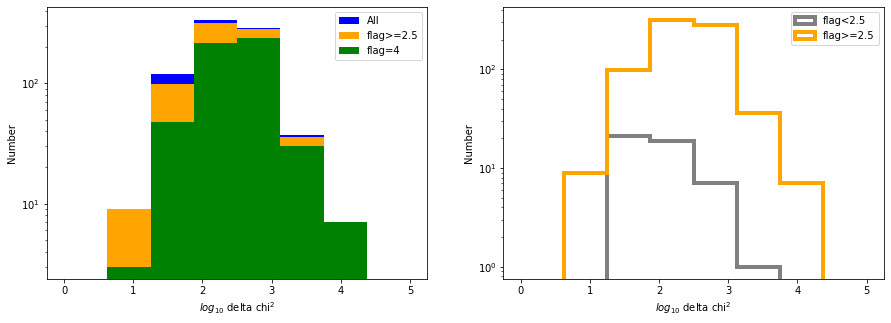

In [36]:
LRG_main = LRG[LRG['setting_name']=='sel0']
print_simple_number(LRG_main,'LRG')
plot_redshift_distribution(LRG_main,'LRG')
plot_chi2_quality_distribution(LRG_main)

In [37]:
catalog_LRG_match = LRG_main.merge(new_catalog_denali,on='TARGETID',how='left',suffixes=("_cascades","_denali"))
final_match_catalog = catalog_LRG_match[catalog_LRG_match['TILEID_cascades']==catalog_LRG_match['TILEID_denali']]

<ipython-input-38-7a8e63dfa79d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog['Redrock_z']=final_match_catalog['Z']


Number of LRG : 802
Number of  LRG with quality>=2.5: 754  | fration= 0.940149625935162
Number of  LRG with quality==4: 543  | fration= 0.6770573566084788
Number of  LRG with consistent z (with quality>=2.5): 641 | fraction= 0.7992518703241895
---------
Fraction of objects with quality>=2.5
Star: 0.09946949602122016
Galaxy: 0.8275862068965517
QSO: 0.07294429708222812


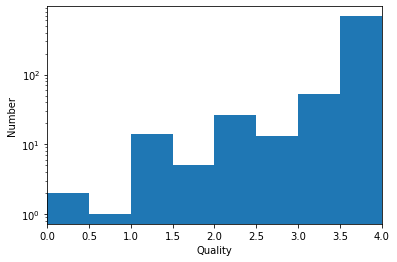

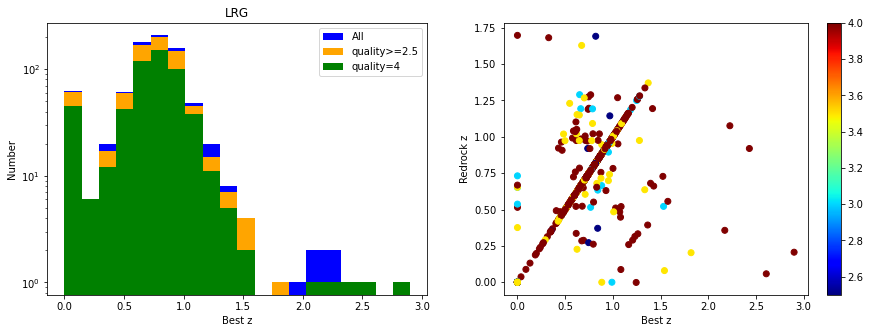

In [38]:
final_match_catalog['Redrock_z']=final_match_catalog['Z']
print_simple_number(final_match_catalog,'LRG')
plot_redshift_distribution(final_match_catalog,'LRG')

In [39]:
final_match_catalog['dz']=abs(final_match_catalog['Z']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])

<ipython-input-39-d90767f6f3de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog['dz']=abs(final_match_catalog['Z']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])


In [40]:
cut_catalog = final_match_catalog[(final_match_catalog['dz']>0.0033) & (final_match_catalog['best_quality']>=2.5)]
print(len(cut_catalog))

113


In [41]:
data_dict ={}
LRG_tile = np.array(cut_catalog['TILEID_denali'])
targetid = np.array(cut_catalog['TARGETID'])
fiberid = np.array(cut_catalog['FIBER'])
last_night = np.array(cut_catalog['LAST_NIGHT'])
print('Targetid, fiberid, tileid')
for i in range(0,len(fiberid)):
    if LRG_tile[i]==80619:
        last_night[i]=20210321
    if LRG_tile[i]==80612.0:
        last_night[i]=20201223 
    if LRG_tile[i]==80684.0:
        last_night[i]=20210305  
    if LRG_tile[i]==80686:
        last_night[i]=20210309    
    if LRG_tile[i]==80689:
        last_night[i]=20210319 
    if LRG_tile[i]==80694:
        last_night[i]=20210306 
        
    if LRG_tile[i]==80699:
        last_night[i]=20210305 
                
    print(targetid[i],fiberid[i],LRG_tile[i],last_night[i])
            
    data_dict[i]=get_specs(tileid=int(LRG_tile[i]), coadd_type='cumulative', night=int(last_night[i]), fiber=int(fiberid[i]))
   

Targetid, fiberid, tileid
39628521902967344 1489 80700 20210208
39628526759970844 1290 80692 20210214
39632930229719071 3502 80700 20210208
39633085146334139 2672 80678 20210206
39633085146335519 2688 80678 20210206
39633085146335989 2668 80678 20210206
39633085146336760 2675 80678 20210206
39633085150528607 2667 80678 20210206
39633134907558134 466 80680 20210208
39633567696815000 2672 80694 20210306
39633567701008493 2671 80694 20210306
39633231393325941 2423 80676 20210109
39633231397521964 2686 80676 20210109
39633267653086707 4343 80711 20210306
39633308153283514 2124 80712 20210222
39633321180792079 4501 80607 20201219
39633324624315924 989 80607 20201219
39633324632703350 783 80607 20201219
39627300953659693 1319 80673 20210206
39627312336997831 3538 80673 20210206
39627779347579375 4397 80669 20210206
39627785341245306 1216 80669 20210206
39627785378989871 4135 80669 20210206
39627797433427265 1155 80669 20210206
39628254935519085 2026 80684 20210305
39628254964876861 3494 8068

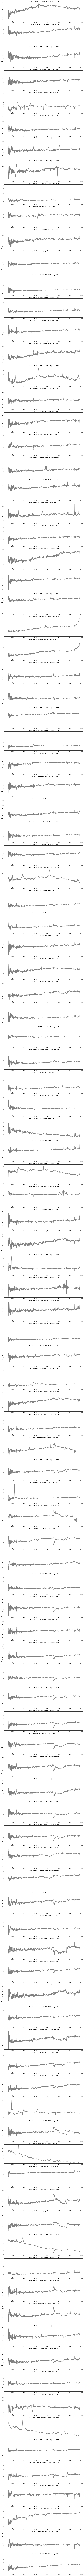

In [42]:
plt.figure(figsize=(15,500))
index = np.argsort(np.array(cut_catalog['Redrock_z']))

for i in range(0,len(index)):
    plt.subplot(len(index),1,i+1)
    plt.plot(data_dict[index[i]][0]['b_wavelength'],sn.median_filter(data_dict[index[i]][0]['b_flux'],10),color='grey')
    plt.plot(data_dict[index[i]][0]['r_wavelength'],sn.median_filter(data_dict[index[i]][0]['r_flux'],10),color='grey')
    plt.plot(data_dict[index[i]][0]['z_wavelength'],sn.median_filter(data_dict[index[i]][0]['z_flux'],10),color='grey')
    plt.title('Denali redrock z:%0.2f Deltachi2:%0.2f | best_z:%0.2f' % (np.array(cut_catalog['Redrock_z'])[index[i]],np.array(cut_catalog['DELTACHI2_denali'])[index[i]],np.array(cut_catalog['best_z'])[index[i]]))

In [43]:
for i in range(0,len(index)):
    print(targetid[index[i]],fiberid[index[i]],LRG_tile[index[i]],np.array(cut_catalog['Redrock_z'])[index[i]])


39632945178216893 2396 80692 -0.0013798348831611663
39633562890145290 4167 80694 -0.0001612027113318904
39633559547284305 76 80694 7.671621067848203e-05
39633203069193052 4697 80676 0.004621707160674389
39633134907558134 466 80680 0.058138356205181804
39632944968503055 2191 80682 0.0801150326341118
39632940086330049 3787 80690 0.08749246700366639
39633331523948144 125 80607 0.2031020679079181
39633338306135335 1703 80607 0.2065241636052483
39633562852393020 1474 80694 0.22673428325287465
39628254964876861 3494 80684 0.2588983349774952
39633341690940914 3571 80607 0.2616583644437156
39633445424466882 1692 80620 0.27232852506928484
39632945132078528 2749 80690 0.28438444561345294
39632950186215795 2745 80690 0.2883111935691271
39628411701825240 1217 80707 0.2895289575177983
39633028649058410 2423 80677 0.3146305882355661
39627797433427265 1155 80669 0.3331383278508785
39632945463428012 2299 80700 0.33592547251376204
39628526759970844 1290 80692 0.3570549468644068
39628317292236716 3995 8

# LRG with z_deep>1.4

Number of LRG : 145
Number of  LRG with quality>=2.5: 107  | fration= 0.7379310344827587
Number of  LRG with quality==4: 73  | fration= 0.503448275862069
Number of  LRG with consistent z (with quality>=2.5): 30 | fraction= 0.20689655172413793
---------
Fraction of objects with quality>=2.5
Star: 0.06542056074766354
Galaxy: 0.35514018691588783
QSO: 0.5794392523364486


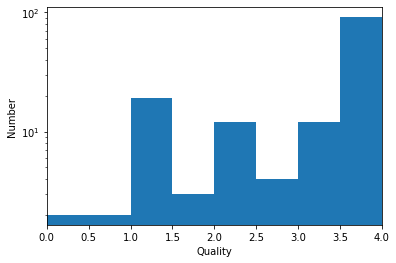

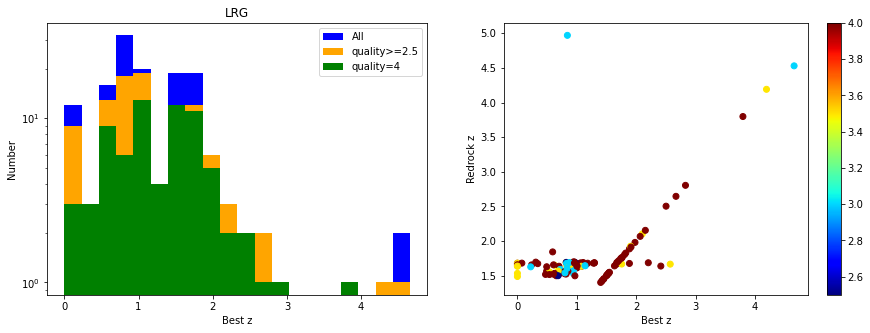

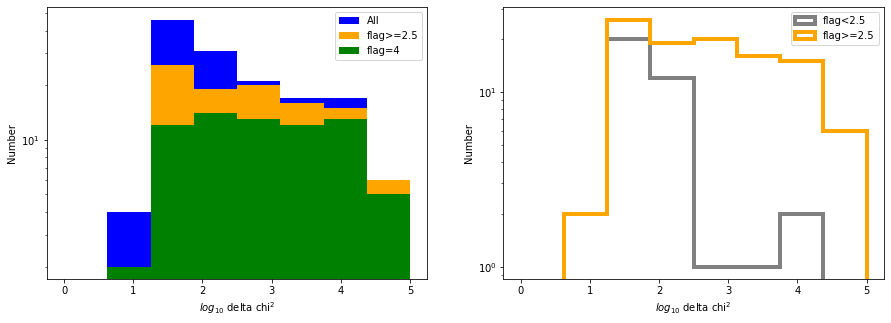

In [44]:
LRG_highz = LRG[LRG['setting_name']=='sel1']
print_simple_number(LRG_highz,'LRG')
plot_redshift_distribution(LRG_highz,'LRG')
plot_chi2_quality_distribution(LRG_highz)

In [45]:
catalog_LRG_match = LRG_highz.merge(new_catalog_denali,on='TARGETID',how='left',suffixes=("_cascades","_denali"))

In [46]:
final_match_catalog = catalog_LRG_match[catalog_LRG_match['TILEID_cascades']==catalog_LRG_match['TILEID_denali']]

### Comparing the Denali redshift and the best z

The consistency increases from 20% to 70%!!

<ipython-input-47-90f8f8ef9f73>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog['Redrock_z']=final_match_catalog['Z']


Number of LRG : 145
Number of  LRG with quality>=2.5: 107  | fration= 0.7379310344827587
Number of  LRG with quality==4: 73  | fration= 0.503448275862069
Number of  LRG with consistent z (with quality>=2.5): 42 | fraction= 0.2896551724137931
---------
Fraction of objects with quality>=2.5
Star: 0.06542056074766354
Galaxy: 0.35514018691588783
QSO: 0.5794392523364486


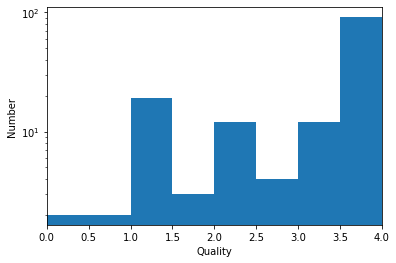

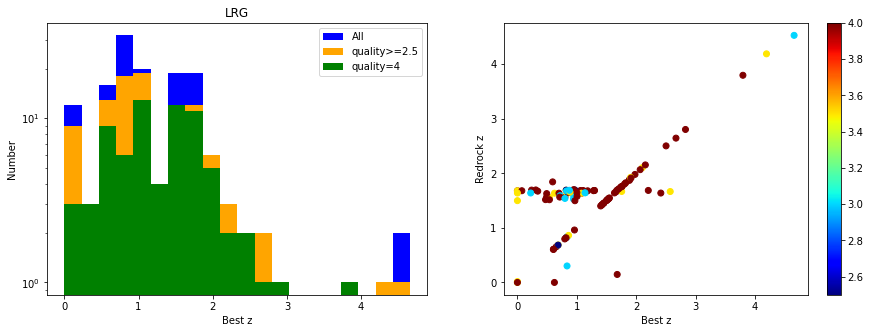

In [47]:
final_match_catalog['Redrock_z']=final_match_catalog['Z']
print_simple_number(final_match_catalog,'LRG')
plot_redshift_distribution(final_match_catalog,'LRG')
#plot_chi2_quality_distribution(final_match_catalog)

In [48]:
final_match_catalog['dz']=abs(final_match_catalog['Z']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])

<ipython-input-48-d90767f6f3de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog['dz']=abs(final_match_catalog['Z']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])


In [49]:
cut_catalog = final_match_catalog[(final_match_catalog['dz']>0.0033) & (final_match_catalog['best_quality']>=2.5)]

In [50]:
len(np.array(cut_catalog['TILEID_denali']))
#for i in range(0,112):
#    print(np.array(cut_catalog['TARGET_RA'])[i],np.array(cut_catalog['TARGET_DEC'])[i])

65

In [51]:
data_dict ={}
LRG_tile = np.array(cut_catalog['TILEID_denali'])
targetid = np.array(cut_catalog['TARGETID'])
fiberid = np.array(cut_catalog['FIBER'])
last_night = np.array(cut_catalog['LAST_NIGHT'])
print('Targetid, fiberid, tileid')
for i in range(0,len(fiberid)):
    if LRG_tile[i]==80619:
        last_night[i]=20210321
    if LRG_tile[i]==80612.0:
        last_night[i]=20201223 
    if LRG_tile[i]==80684.0:
        last_night[i]=20210305  
    if LRG_tile[i]==80686:
        last_night[i]=20210309    
    if LRG_tile[i]==80689:
        last_night[i]=20210319 
    if LRG_tile[i]==80694:
        last_night[i]=20210306 
        
    if LRG_tile[i]==80699:
        last_night[i]=20210305 
                
        
            
    print(targetid[i],fiberid[i],LRG_tile[i],last_night[i])
    data_dict[i]=get_specs(tileid=int(LRG_tile[i]), coadd_type='cumulative', night=int(last_night[i]), fiber=int(fiberid[i]))
   

Targetid, fiberid, tileid
39627335120459095 2207 80673 20210206
39627815557012511 2260 80669 20210206
39627865775407811 3154 80610 20210208
39628121854447882 524 80683 20210206
39628203320410477 998 80684 20210305
39628214879912213 4435 80684 20210305
39628243535401355 2966 80684 20210305
39628249256432112 3015 80684 20210305
39628254956492938 3057 80684 20210305
39628406333117236 4035 80707 20210208
39628433235381134 2111 80707 20210208
39628501233435274 4783 80699 20210305
39628511555619266 991 80699 20210305
39628511568200569 959 80622 20201221
39628516764944265 1098 80700 20210208
39628521429009553 1120 80682 20210109
39628526567035268 1197 80682 20210109
39628527040988659 1412 80700 20210208
39632934713430648 3945 80681 20210109
39632944993667670 4720 80686 20210309
39632945081745941 3378 80689 20210319
39632945203381785 3368 80692 20210214
39632950039414726 2685 80682 20210109
39633190620497955 62 80676 20210109
39633198937805554 4584 80676 20210109
39633203044027868 1115 80676 2

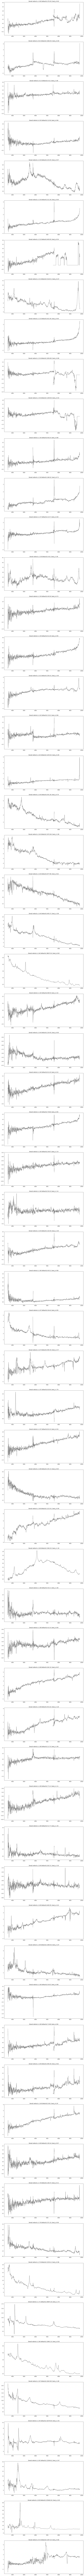

In [52]:
plt.figure(figsize=(15,500))
index = np.argsort(np.array(cut_catalog['Redrock_z']))

for i in range(0,65):
    plt.subplot(65,1,i+1)
    plt.plot(data_dict[index[i]][0]['b_wavelength'],sn.median_filter(data_dict[index[i]][0]['b_flux'],20),color='grey')
    plt.plot(data_dict[index[i]][0]['r_wavelength'],sn.median_filter(data_dict[index[i]][0]['r_flux'],20),color='grey')
    plt.plot(data_dict[index[i]][0]['z_wavelength'],sn.median_filter(data_dict[index[i]][0]['z_flux'],20),color='grey')
    plt.title('Denali redrock z:%0.2f Deltachi2:%0.2f | best_z:%0.2f' % (np.array(cut_catalog['Redrock_z'])[index[i]],np.array(cut_catalog['DELTACHI2_denali'])[index[i]],np.array(cut_catalog['best_z'])[index[i]]))